In [36]:
import torch
from lime import lime_image
from yolo_threat import YoloThreat
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

In [37]:
def compute_faithfulness(image, label, explanation, predict_fn):
    label = int(label)
    _, mask = explanation.get_image_and_mask(label=label, positive_only=True, num_features=10, hide_rest=False)

    if mask.shape != image.shape[:2]:
        raise ValueError(f"Mask shape {mask.shape} does not match image shape {image.shape[:2]}.")

    masked_image = image * mask[:, :, np.newaxis]
    predictions = predict_fn([image])
    if label >= predictions.shape[1]:
        raise IndexError(f"Label {label} is out of bounds for classifier output.")
    original_prediction = predictions[0, label]
    prediction_with_mask = predict_fn([masked_image])[0, label]
    return original_prediction - prediction_with_mask

In [44]:
def analyze_lime(image, label, explainer, predict_fn):
    # Ensure input image is in (H, W, 3) format
    if len(image.shape) == 3 and image.shape[0] == 3:
        image = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

    image = (image * 255).astype(np.uint8)  # Scale to 0-255 for LIME compatibility

    # Generate LIME explanation
    explanation = explainer.explain_instance(
        image=image,
        classifier_fn=predict_fn,
        labels=[label],
        hide_color=0,
        num_samples=1000,
    )

    # Debug: Check if the label exists in the explanation
    if label not in explanation.local_exp:
        print(f"Available labels in explanation: {list(explanation.local_exp.keys())}")
        raise KeyError(f"Label {label} not in explanation. Check if the model predicts this label.")

    # Compute metrics
    faithfulness_score = compute_faithfulness(image, label, explanation, predict_fn)
    print(f"Faithfulness score: {faithfulness_score}")

    return explanation, faithfulness_score

In [39]:
Xtest = torch.load('../data/danger/raw/test.pt')
ytest = torch.load('../data/danger/raw/test_labels.pt')
Xtest.shape, ytest.shape

(torch.Size([2185, 3, 128, 128]), torch.Size([2185]))

In [40]:
model = YoloThreat.load_new_model()
model.eval()

Using cache found in /Users/harshitsingh/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-22 Python-3.12.2 torch-2.2.2 CPU

Fusing layers... 
YOLOv5n6 summary: 280 layers, 3239884 parameters, 0 gradients
Adding AutoShape... 


YoloThreat(
  (yolo): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
        

In [52]:
def predict_fn(images):
    if not isinstance(images, torch.Tensor):
        images = torch.tensor(images, dtype=torch.float32)

    if len(images.shape) == 3:
        images = images.unsqueeze(0)

    if images.shape[1] != 3:
        images = images.permute(0, 3, 1, 2)
    outputs = model.predict(images)

    return outputs.detach().cpu().numpy()

In [53]:
explainer = lime_image.LimeImageExplainer()

In [54]:
try:
    # Ensure label is an integer
    actual_label = int(ytest[0].item())

    # Run the model to get predictions for the input image
    image_for_prediction = Xtest[0].unsqueeze(0).permute(0, 2, 3, 1).numpy()  # Convert (C, H, W) to (H, W, C) for predict_fn
    predictions = predict_fn(image_for_prediction)
    predicted_label = int(np.argmax(predictions, axis=1)[0])  # Top predicted label

    # Debug: Print actual and predicted labels
    print(f"Actual Label: {actual_label}, Predicted Label: {predicted_label}")

    # Use the predicted label for LIME if the requested label is not available
    label_to_explain = predicted_label
    if actual_label != predicted_label:
        print(f"Warning: Requested label {actual_label} is not in predictions. Falling back to predicted label {predicted_label}.")

    # Perform LIME Analysis
    explanation, faithfulness_score = analyze_lime(Xtest[0], label_to_explain, explainer, predict_fn)

    # Visualize Results
    temp, mask = explanation.get_image_and_mask(label=label_to_explain, positive_only=True, num_features=10, hide_rest=False)

except Exception as e:
    print(f"Error during LIME analysis: {e}")

Actual Label: 1, Predicted Label: 0


100%|██████████| 1000/1000 [00:14<00:00, 66.79it/s]


Faithfulness score: -0.02924114465713501


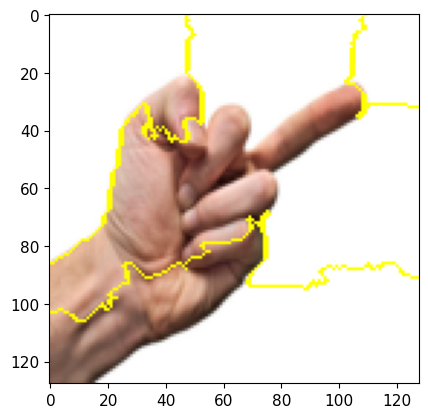

In [55]:
%matplotlib inline
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

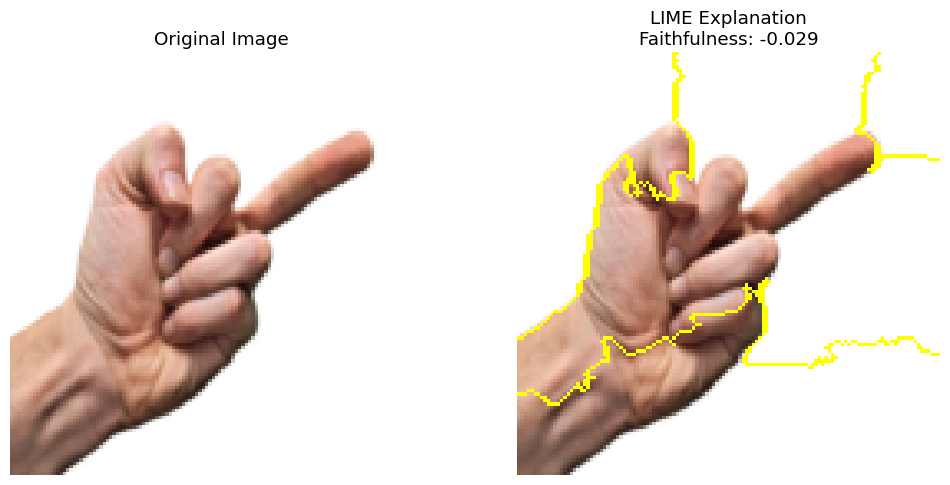

<Figure size 1200x600 with 0 Axes>

In [56]:
%matplotlib inline

image = Xtest[0].permute(1, 2, 0).numpy() * 255
label = label_to_explain
temp = Xtest[0].permute(1, 2, 0).numpy() * 255
mask = mask
faithfulness_score = faithfulness_score
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.figure(figsize=(12, 6))
axs[0].imshow(image / 255.0)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(mark_boundaries(temp / 255.0, mask))
axs[1].set_title(f"LIME Explanation\nFaithfulness: {faithfulness_score:.3f}")
axs[1].axis("off")

plt.tight_layout()
plt.show()